# Convolutions with LSTM

## CNN + RNN

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def trend_f(time,slope):
    trend=time*slope
    return trend
def season_f(time,period):
    season=(time%period)/period
    return season
def seasonality_f(sason_time,amplitude):
    data_pattern = np.where(season_time < 0.4,np.cos(season_time * 2 * np.pi),1 / np.exp(3 * season_time))
    seasonality=amplitude*data_pattern
    return seasonality
def noise_f(time,noise_level):
    rnd = np.random.RandomState(42)
    noise = rnd.randn(len(time))*noise_level
    return noise

#### data

In [3]:
slope=0.05
period=365
amplitude=40
noise_level=5
baseline=10
time=np.arange(365*4+1)

trend=trend_f(time,slope)
season_time=season_f(time,period)
seasonality=seasonality_f(season_time,amplitude)
noise = noise_f(time,noise_level)

series=baseline+noise+trend+seasonality

Text(0, 0.5, 'value')

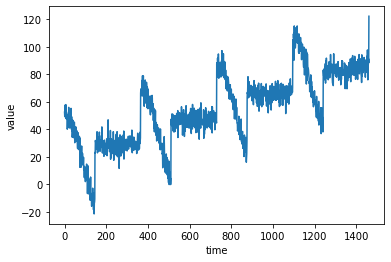

In [4]:
plt.plot(time, series)
plt.xlabel('time')
plt.ylabel('value')

In [5]:
split_time=1000
x_train=series[:split_time]
x_val=series[split_time:]
time_train=time[:split_time]
time_val=time[split_time:]

In [7]:
window=20
batch=16
shuffle_buffer=1000

In [8]:
def windowed_data(series,window,batch,shuffle_buffer):
    data=tf.data.Dataset.from_tensor_slices(series)
    data=data.window(window+1,shift=1,drop_remainder=True)
    data=data.flat_map(lambda i: i.batch(window+1))
    data=data.map(lambda i: (i[:-1], i[-1]))
    data=data.shuffle(shuffle_buffer)
    data=data.batch(batch).prefetch(1)
    return data

In [9]:
dataset=windowed_data(series,window,batch,shuffle_buffer)

#### model

In [10]:
tf.keras.backend.clear_session()

In [21]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64,kernel_size=3,strides=1,padding='causal',activation='relu',input_shape=[window,1]),
    tf.keras.layers.LSTM(64,return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*400)
])
init_weights = model.get_weights()
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_7 (Conv1D)           (None, 20, 64)            256       
                                                                 
 lstm_12 (LSTM)              (None, 20, 64)            33024     
                                                                 
 lstm_13 (LSTM)              (None, 64)                33024     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
 lambda_6 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 66,369
Trainable params: 66,369
Non-trainable params: 0
_________________________________________________________________


#### tuning learning rate

In [17]:
lr_schedule=tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))
model.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9),loss=tf.keras.losses.Huber(),metrics=['mae'])
history=model.fit(dataset,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
91/91 [==============================] - 5s 22ms/step - loss: 65.3787 - accuracy: 0.0000e+00 - lr: 1.0000e-08
Epoch 2/100
91/91 [==============================] - 1s 15ms/step - loss: 24.5767 - accuracy: 0.0000e+00 - lr: 1.1220e-08
Epoch 3/100
91/91 [==============================] - 1s 14ms/step - loss: 16.8481 - accuracy: 0.0000e+00 - lr: 1.2589e-08
Epoch 4/100
91/91 [==============================] - 2s 16ms/step - loss: 13.0404 - accuracy: 0.0000e+00 - lr: 1.4125e-08
Epoch 5/100
91/91 [==============================] - 1s 14ms/step - loss: 10.8022 - accuracy: 0.0000e+00 - lr: 1.5849e-08
Epoch 6/100
91/91 [==============================] - 1s 13ms/step - loss: 9.6922 - accuracy: 0.0000e+00 - lr: 1.7783e-08
Epoch 7/100
91/91 [==============================] - 1s 13ms/step - loss: 8.9420 - accuracy: 0.0000e+00 - lr: 1.9953e-08
Epoch 8/100
91/91 [==============================] - 1s 13ms/step - loss: 8.3978 - accuracy: 0.0000e+00 - lr: 2.2387e-08
Epoch 9/100
91/91 [========

91/91 [==============================] - 2s 15ms/step - loss: 9.7867 - accuracy: 0.0000e+00 - lr: 2.2387e-05
Epoch 69/100
91/91 [==============================] - 2s 16ms/step - loss: 11.2651 - accuracy: 0.0000e+00 - lr: 2.5119e-05
Epoch 70/100
91/91 [==============================] - 2s 17ms/step - loss: 7.2271 - accuracy: 0.0000e+00 - lr: 2.8184e-05
Epoch 71/100
91/91 [==============================] - 1s 14ms/step - loss: 8.4154 - accuracy: 0.0000e+00 - lr: 3.1623e-05
Epoch 72/100
91/91 [==============================] - 2s 16ms/step - loss: 9.7299 - accuracy: 0.0000e+00 - lr: 3.5481e-05
Epoch 73/100
91/91 [==============================] - 1s 14ms/step - loss: 12.6429 - accuracy: 0.0000e+00 - lr: 3.9811e-05
Epoch 74/100
91/91 [==============================] - 2s 15ms/step - loss: 7.8558 - accuracy: 0.0000e+00 - lr: 4.4668e-05
Epoch 75/100
91/91 [==============================] - 1s 15ms/step - loss: 8.0781 - accuracy: 0.0000e+00 - lr: 5.0119e-05
Epoch 76/100
91/91 [===============

(1e-08, 0.001, 0.0, 50.0)

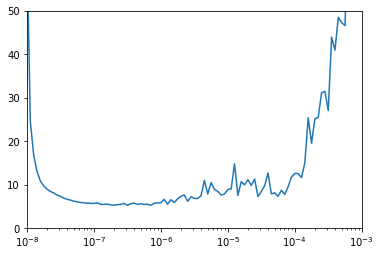

In [19]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 50])

#### model training

In [22]:
tf.keras.backend.clear_session()
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64,kernel_size=3,strides=1,padding='causal',activation='relu',input_shape=[window,1]),
    tf.keras.layers.LSTM(64,return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*400)
])
model.set_weights(init_weights) # instad of definign model again^^ we can reset weights
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-7,momentum=0.9),loss=tf.keras.losses.Huber(),metrics=['mae'])
history=model.fit(dataset,epochs=100)

Epoch 1/100
91/91 [==============================] - 4s 14ms/step - loss: 33.5268 - accuracy: 0.0000e+00
Epoch 2/100
91/91 [==============================] - 1s 13ms/step - loss: 6.2578 - accuracy: 0.0000e+00
Epoch 3/100
91/91 [==============================] - 1s 13ms/step - loss: 6.1291 - accuracy: 0.0000e+00
Epoch 4/100
91/91 [==============================] - 1s 14ms/step - loss: 6.0963 - accuracy: 0.0000e+00
Epoch 5/100
91/91 [==============================] - 1s 14ms/step - loss: 6.0630 - accuracy: 0.0000e+00
Epoch 6/100
91/91 [==============================] - 1s 13ms/step - loss: 5.8301 - accuracy: 0.0000e+00
Epoch 7/100
91/91 [==============================] - 1s 13ms/step - loss: 5.9171 - accuracy: 0.0000e+00
Epoch 8/100
91/91 [==============================] - 1s 14ms/step - loss: 5.7746 - accuracy: 0.0000e+00
Epoch 9/100
91/91 [==============================] - 1s 14ms/step - loss: 5.8777 - accuracy: 0.0000e+00
Epoch 10/100
91/91 [==============================] - 1s 13ms/s

91/91 [==============================] - 1s 15ms/step - loss: 4.7902 - accuracy: 0.0000e+00
Epoch 80/100
91/91 [==============================] - 1s 15ms/step - loss: 4.8949 - accuracy: 0.0000e+00
Epoch 81/100
91/91 [==============================] - 1s 15ms/step - loss: 4.8313 - accuracy: 0.0000e+00
Epoch 82/100
91/91 [==============================] - 2s 15ms/step - loss: 4.7937 - accuracy: 0.0000e+00
Epoch 83/100
91/91 [==============================] - 1s 15ms/step - loss: 4.8119 - accuracy: 0.0000e+00
Epoch 84/100
91/91 [==============================] - 1s 15ms/step - loss: 4.9413 - accuracy: 0.0000e+00
Epoch 85/100
91/91 [==============================] - 1s 15ms/step - loss: 4.7738 - accuracy: 0.0000e+00
Epoch 86/100
91/91 [==============================] - 1s 15ms/step - loss: 4.9413 - accuracy: 0.0000e+00
Epoch 87/100
91/91 [==============================] - 1s 15ms/step - loss: 4.8086 - accuracy: 0.0000e+00
Epoch 88/100
91/91 [==============================] - 1s 15ms/step -

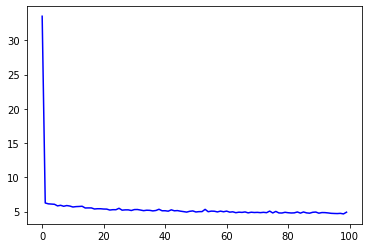

In [23]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')

#### prediction

In [24]:
def model_forecast(model, series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset)
    return forecast

In [25]:
forecast_series = series[split_time-window:-1]
forecast = model_forecast(model, forecast_series, window, batch)
results = forecast.squeeze()

29/29 [==============================] - 1s 5ms/step


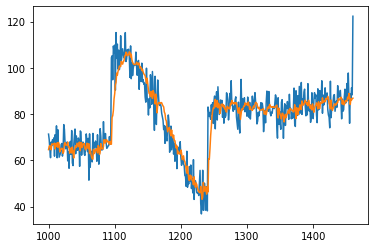

In [26]:
results=np.array(forecast).squeeze()
plt.plot(time_val, x_val)
plt.plot(time_val, results)

In [27]:
print(tf.keras.metrics.mean_squared_error(x_val, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_val, results).numpy())

47.793194
4.976859


---

## DNN

In [28]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

#### data

In [30]:
time_step = []
sunspots = []

with open('data/Sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))
    
time = np.array(time_step)
series = np.array(sunspots)

Text(0, 0.5, 'value')

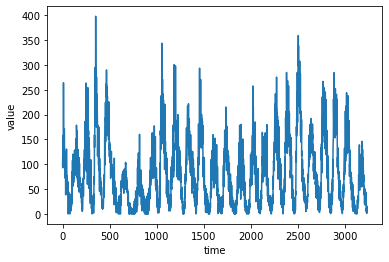

In [31]:
plt.plot(time, series)
plt.xlabel('time')
plt.ylabel('value')

In [36]:
split_time=3000
x_train=series[:split_time]
x_val=series[split_time:]
time_train=time[:split_time]
time_val=time[split_time:]

In [37]:
window=30
batch=32
shuffle_buffer=1000

In [38]:
def windowed_data(series,window,batch,shuffle_buffer):
    data=tf.data.Dataset.from_tensor_slices(series)
    data=data.window(window+1,shift=1,drop_remainder=True)
    data=data.flat_map(lambda i: i.batch(window+1))
    data=data.map(lambda i: (i[:-1], i[-1]))
    data=data.shuffle(shuffle_buffer)
    data=data.batch(batch).prefetch(1)
    return data

In [39]:
dataset=windowed_data(series,window,batch,shuffle_buffer)

#### model

In [42]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Dense(30,activation='relu',input_shape=[window]),
    tf.keras.layers.Dense(15,activation='relu'),
    tf.keras.layers.Dense(1)
])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 30)                930       
                                                                 
 dense_10 (Dense)            (None, 15)                465       
                                                                 
 dense_11 (Dense)            (None, 1)                 16        
                                                                 
Total params: 1,411
Trainable params: 1,411
Non-trainable params: 0
_________________________________________________________________


#### tuning learning rate

In [43]:
lr_schedule=tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))
model.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9),loss=tf.keras.losses.Huber(),metrics=['mae'])
history=model.fit(dataset,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
101/101 [==============================] - 1s 2ms/step - loss: 115.7492 - accuracy: 0.0178 - lr: 1.0000e-08
Epoch 2/100
101/101 [==============================] - 0s 2ms/step - loss: 114.8214 - accuracy: 0.0178 - lr: 1.1220e-08
Epoch 3/100
101/101 [==============================] - 0s 2ms/step - loss: 113.7726 - accuracy: 0.0178 - lr: 1.2589e-08
Epoch 4/100
101/101 [==============================] - 0s 2ms/step - loss: 112.6141 - accuracy: 0.0178 - lr: 1.4125e-08
Epoch 5/100
101/101 [==============================] - 0s 2ms/step - loss: 111.3144 - accuracy: 0.0178 - lr: 1.5849e-08
Epoch 6/100
101/101 [==============================] - 0s 2ms/step - loss: 109.8731 - accuracy: 0.0175 - lr: 1.7783e-08
Epoch 7/100
101/101 [==============================] - 0s 2ms/step - loss: 108.2642 - accuracy: 0.0168 - lr: 1.9953e-08
Epoch 8/100
101/101 [==============================] - 0s 2ms/step - loss: 106.4653 - accuracy: 0.0168 - lr: 2.2387e-08
Epoch 9/100
101/101 [===================

101/101 [==============================] - 0s 2ms/step - loss: 17.6566 - accuracy: 0.0053 - lr: 2.5119e-05
Epoch 70/100
101/101 [==============================] - 0s 2ms/step - loss: 17.6378 - accuracy: 0.0053 - lr: 2.8184e-05
Epoch 71/100
101/101 [==============================] - 0s 2ms/step - loss: 17.4495 - accuracy: 0.0044 - lr: 3.1623e-05
Epoch 72/100
101/101 [==============================] - 0s 2ms/step - loss: 17.8515 - accuracy: 0.0050 - lr: 3.5481e-05
Epoch 73/100
101/101 [==============================] - 0s 2ms/step - loss: 17.1902 - accuracy: 0.0034 - lr: 3.9811e-05
Epoch 74/100
101/101 [==============================] - 0s 2ms/step - loss: 17.3476 - accuracy: 0.0041 - lr: 4.4668e-05
Epoch 75/100
101/101 [==============================] - 0s 3ms/step - loss: 17.4746 - accuracy: 0.0041 - lr: 5.0119e-05
Epoch 76/100
101/101 [==============================] - 0s 3ms/step - loss: 17.9352 - accuracy: 0.0037 - lr: 5.6234e-05
Epoch 77/100
101/101 [==============================]

(1e-08, 0.001, 0.0, 50.0)

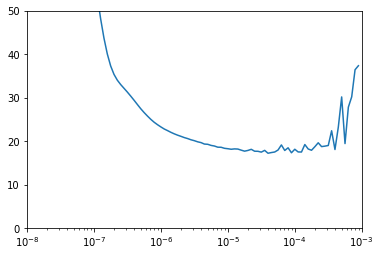

In [44]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 50])

#### model training

In [46]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Dense(30,activation='relu',input_shape=[window]),
    tf.keras.layers.Dense(15,activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=2e-5,momentum=0.9),loss=tf.keras.losses.Huber(),metrics=['mae'])
history=model.fit(dataset,epochs=100)

Epoch 1/100
101/101 [==============================] - 1s 2ms/step - loss: 23.1327 - mae: 23.6270
Epoch 2/100
101/101 [==============================] - 0s 2ms/step - loss: 19.7204 - mae: 20.2127
Epoch 3/100
101/101 [==============================] - 0s 2ms/step - loss: 18.9221 - mae: 19.4162
Epoch 4/100
101/101 [==============================] - 0s 2ms/step - loss: 18.3281 - mae: 18.8200
Epoch 5/100
101/101 [==============================] - 0s 2ms/step - loss: 17.9856 - mae: 18.4783
Epoch 6/100
101/101 [==============================] - 0s 2ms/step - loss: 18.1232 - mae: 18.6168
Epoch 7/100
101/101 [==============================] - 0s 2ms/step - loss: 17.6693 - mae: 18.1624
Epoch 8/100
101/101 [==============================] - 0s 2ms/step - loss: 17.5977 - mae: 18.0905
Epoch 9/100
101/101 [==============================] - 0s 2ms/step - loss: 17.4469 - mae: 17.9380
Epoch 10/100
101/101 [==============================] - 0s 3ms/step - loss: 17.6179 - mae: 18.1088
Epoch 11/100
101/10

101/101 [==============================] - 0s 2ms/step - loss: 16.6012 - mae: 17.0922
Epoch 84/100
101/101 [==============================] - 0s 3ms/step - loss: 16.4540 - mae: 16.9450
Epoch 85/100
101/101 [==============================] - 0s 3ms/step - loss: 16.5552 - mae: 17.0453
Epoch 86/100
101/101 [==============================] - 0s 3ms/step - loss: 16.4830 - mae: 16.9742
Epoch 87/100
101/101 [==============================] - 0s 3ms/step - loss: 16.4754 - mae: 16.9659
Epoch 88/100
101/101 [==============================] - 0s 3ms/step - loss: 16.2969 - mae: 16.7865
Epoch 89/100
101/101 [==============================] - 0s 2ms/step - loss: 16.4040 - mae: 16.8953
Epoch 90/100
101/101 [==============================] - 0s 2ms/step - loss: 16.6407 - mae: 17.1325
Epoch 91/100
101/101 [==============================] - 0s 3ms/step - loss: 16.5781 - mae: 17.0688
Epoch 92/100
101/101 [==============================] - 0s 3ms/step - loss: 16.3058 - mae: 16.7960
Epoch 93/100
101/101 [=

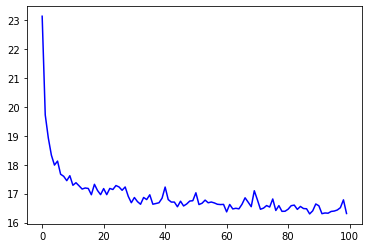

In [47]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')

#### prediction

In [48]:
def model_forecast(model, series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset)
    return forecast

In [49]:
forecast_series = series[split_time-window:-1]
forecast = model_forecast(model, forecast_series, window, batch)
results = forecast.squeeze()

8/8 [==============================] - 0s 5ms/step


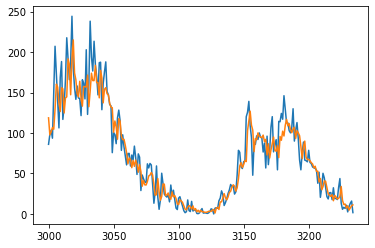

In [50]:
results=np.array(forecast).squeeze()
plt.plot(time_val, x_val)
plt.plot(time_val, results)

In [51]:
print(tf.keras.metrics.mean_squared_error(x_val, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_val, results).numpy())

410.42496
13.844117


---

## CNN + DNN + LSTM

In [56]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import csv

#### data

In [52]:
time_step = []
sunspots = []

with open('data/Sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    time_step.append(int(row[0]))
    sunspots.append(float(row[2]))
    
time = np.array(time_step)
series = np.array(sunspots)

Text(0, 0.5, 'value')

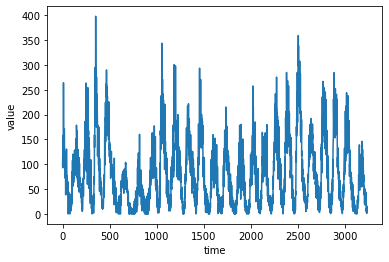

In [53]:
plt.plot(time, series)
plt.xlabel('time')
plt.ylabel('value')

In [54]:
split_time=3000
x_train=series[:split_time]
x_val=series[split_time:]
time_train=time[:split_time]
time_val=time[split_time:]

In [57]:
window=30
batch=32
shuffle_buffer=1000

In [58]:
def windowed_data(series,window,batch,shuffle_buffer):
    data=tf.data.Dataset.from_tensor_slices(series)
    data=data.window(window+1,shift=1,drop_remainder=True)
    data=data.flat_map(lambda i: i.batch(window+1))
    data=data.map(lambda i: (i[:-1], i[-1]))
    data=data.shuffle(shuffle_buffer)
    data=data.batch(batch).prefetch(1)
    return data

In [59]:
dataset=windowed_data(series,window,batch,shuffle_buffer)

#### model

In [61]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=64,kernel_size=3,strides=1,activation='relu',padding='causal',input_shape=[window,1]),
    tf.keras.layers.LSTM(64,return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(30,activation='relu'),
    tf.keras.layers.Dense(10,activation='relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*400)
])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 30, 64)            256       
                                                                 
 lstm_16 (LSTM)              (None, 30, 64)            33024     
                                                                 
 lstm_17 (LSTM)              (None, 64)                33024     
                                                                 
 dense_18 (Dense)            (None, 30)                1950      
                                                                 
 dense_19 (Dense)            (None, 10)                310       
                                                                 
 dense_20 (Dense)            (None, 1)                 11        
                                                                 
 lambda_8 (Lambda)           (None, 1)               

#### tuning learning rate

In [62]:
lr_schedule=tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/20))
model.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9),loss=tf.keras.losses.Huber(),metrics=['mae'])
history=model.fit(dataset,epochs=100,callbacks=[lr_schedule])

Epoch 1/100
101/101 [==============================] - 6s 24ms/step - loss: 53.4420 - mae: 53.9406 - lr: 1.0000e-08
Epoch 2/100
101/101 [==============================] - 3s 24ms/step - loss: 47.8698 - mae: 48.3682 - lr: 1.1220e-08
Epoch 3/100
101/101 [==============================] - 3s 24ms/step - loss: 43.7087 - mae: 44.2057 - lr: 1.2589e-08
Epoch 4/100
101/101 [==============================] - 3s 24ms/step - loss: 40.2186 - mae: 40.7165 - lr: 1.4125e-08
Epoch 5/100
101/101 [==============================] - 3s 24ms/step - loss: 37.0875 - mae: 37.5849 - lr: 1.5849e-08
Epoch 6/100
101/101 [==============================] - 3s 24ms/step - loss: 34.2569 - mae: 34.7539 - lr: 1.7783e-08
Epoch 7/100
101/101 [==============================] - 2s 23ms/step - loss: 31.7571 - mae: 32.2538 - lr: 1.9953e-08
Epoch 8/100
101/101 [==============================] - 2s 23ms/step - loss: 29.7695 - mae: 30.2644 - lr: 2.2387e-08
Epoch 9/100
101/101 [==============================] - 2s 23ms/step - lo

101/101 [==============================] - 3s 28ms/step - loss: 21.8298 - mae: 22.3247 - lr: 3.1623e-05
Epoch 72/100
101/101 [==============================] - 3s 28ms/step - loss: 22.2652 - mae: 22.7594 - lr: 3.5481e-05
Epoch 73/100
101/101 [==============================] - 3s 28ms/step - loss: 21.6003 - mae: 22.0945 - lr: 3.9811e-05
Epoch 74/100
101/101 [==============================] - 3s 28ms/step - loss: 20.9327 - mae: 21.4269 - lr: 4.4668e-05
Epoch 75/100
101/101 [==============================] - 3s 28ms/step - loss: 22.3574 - mae: 22.8518 - lr: 5.0119e-05
Epoch 76/100
101/101 [==============================] - 3s 29ms/step - loss: 22.0954 - mae: 22.5898 - lr: 5.6234e-05
Epoch 77/100
101/101 [==============================] - 3s 28ms/step - loss: 20.0157 - mae: 20.5110 - lr: 6.3096e-05
Epoch 78/100
101/101 [==============================] - 3s 30ms/step - loss: 20.8866 - mae: 21.3804 - lr: 7.0795e-05
Epoch 79/100
101/101 [==============================] - 3s 30ms/step - loss: 

(1e-08, 0.001, 0.0, 50.0)

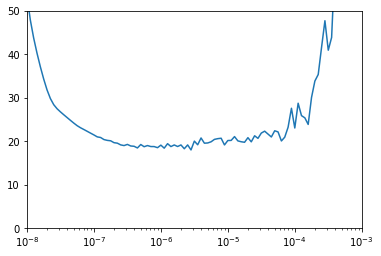

In [64]:
lrs = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(lrs, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 50])

#### model training

In [65]:
model=tf.keras.models.Sequential([
    tf.keras.layers.Dense(30,activation='relu',input_shape=[window]),
    tf.keras.layers.Dense(15,activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6,momentum=0.9),loss=tf.keras.losses.Huber(),metrics=['mae'])
history=model.fit(dataset,epochs=100)

Epoch 1/100
101/101 [==============================] - 1s 2ms/step - loss: 60.8762 - mae: 61.3738
Epoch 2/100
101/101 [==============================] - 0s 2ms/step - loss: 43.1977 - mae: 43.6937
Epoch 3/100
101/101 [==============================] - 0s 2ms/step - loss: 37.0614 - mae: 37.5576
Epoch 4/100
101/101 [==============================] - 0s 2ms/step - loss: 33.5111 - mae: 34.0069
Epoch 5/100
101/101 [==============================] - 0s 2ms/step - loss: 31.2281 - mae: 31.7234
Epoch 6/100
101/101 [==============================] - 0s 2ms/step - loss: 29.6245 - mae: 30.1197
Epoch 7/100
101/101 [==============================] - 0s 2ms/step - loss: 28.3500 - mae: 28.8443
Epoch 8/100
101/101 [==============================] - 0s 2ms/step - loss: 27.3436 - mae: 27.8372
Epoch 9/100
101/101 [==============================] - 0s 2ms/step - loss: 26.5234 - mae: 27.0169
Epoch 10/100
101/101 [==============================] - 0s 2ms/step - loss: 25.8587 - mae: 26.3526
Epoch 11/100
101/10

101/101 [==============================] - 0s 2ms/step - loss: 17.9275 - mae: 18.4195
Epoch 84/100
101/101 [==============================] - 0s 3ms/step - loss: 17.9054 - mae: 18.3974
Epoch 85/100
101/101 [==============================] - 0s 3ms/step - loss: 17.9019 - mae: 18.3947
Epoch 86/100
101/101 [==============================] - 0s 3ms/step - loss: 17.8584 - mae: 18.3496
Epoch 87/100
101/101 [==============================] - 0s 3ms/step - loss: 17.8557 - mae: 18.3475
Epoch 88/100
101/101 [==============================] - 0s 3ms/step - loss: 17.8534 - mae: 18.3441
Epoch 89/100
101/101 [==============================] - 0s 3ms/step - loss: 17.8578 - mae: 18.3495
Epoch 90/100
101/101 [==============================] - 0s 3ms/step - loss: 17.8258 - mae: 18.3173
Epoch 91/100
101/101 [==============================] - 0s 3ms/step - loss: 17.7964 - mae: 18.2884
Epoch 92/100
101/101 [==============================] - 0s 3ms/step - loss: 17.7790 - mae: 18.2706
Epoch 93/100
101/101 [=

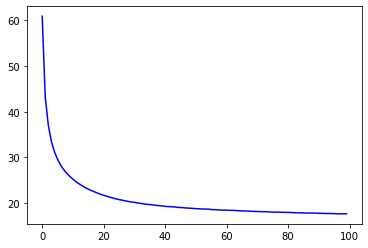

In [66]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')

#### prediction

In [67]:
def model_forecast(model, series, window_size, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    dataset = dataset.batch(batch_size).prefetch(1)
    forecast = model.predict(dataset)
    return forecast

In [68]:
forecast_series = series[split_time-window:-1]
forecast = model_forecast(model, forecast_series, window, batch)
results = forecast.squeeze()

8/8 [==============================] - 0s 5ms/step


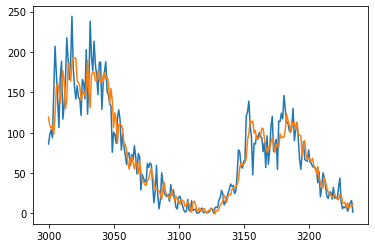

In [69]:
results=np.array(forecast).squeeze()
plt.plot(time_val, x_val)
plt.plot(time_val, results)

In [70]:
print(tf.keras.metrics.mean_squared_error(x_val, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_val, results).numpy())

484.3338
14.907427


#### dynamic learning rate adjusting

In [ ]:
initial_learning_rate=1e-7
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate,decay_steps=400,decay_rate=0.96,staircase=True)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule,momentum=0.9),loss=tf.keras.losses.Huber(),metrics=['mae'])
history=model.fit(dataset,epochs=100)